# Flower Recognition CNN

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
%cd drive/MyDrive
!ls
!unzip = archive.zip # my zip file name

#### Packages and Libraries

In [ ]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
import os
import cv2
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from collections import Counter
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

#### Classification
As well as intializing the working directory

In [ ]:
# Categories of flowers we want to classify
categories = ['dandelion', 'daisy', 'sunflower', 'tulip', 'rose']

# Data directory
data_directory = '/content/drive/MyDrive/flowers'

#### Loading and iterating the data

In [ ]:
# Load and preprocess the image data
features = []
# Iterate through each category and assign a class index to each
for category in categories:
    path = os.path.join(data_directory, category)
    class_index = categories.index(category)
    # Iterate through each image in the data directory
    for img in os.listdir(path):
        if img.endswith('.jpg'):
            img_array = cv2.imread(os.path.join(path, img), cv2.IMREAD_COLOR)
            img_array = cv2.resize(img_array, (150, 150))
            features.append([img_array, class_index])

#### Checking path existence

In [ ]:
# Specify paths without leading slash
dandelion_path = '/content/drive/MyDrive/flowers/dandelion'

# Check if the directory exists
if os.path.exists(dandelion_path):
    class_index = categories.index(category)
    for img in os.listdir(dandelion_path):
        if img.endswith('.jpg'):
            img_array = cv2.imread(os.path.join(dandelion_path, img), cv2.IMREAD_COLOR)
else:
    print(f"The directory {dandelion_path} does not exist.")

#### Preprocessing

Separating the features and labels from the data

In [ ]:
X = []
y = []
# Iterate through each image in the data directory
for img, label in features:
    X.append(img)
    y.append(label)

Reshape and normalize the image data

In [ ]:
# Convert the lists to NumPy arrays and normalize the image data
X = np.array(X) / 255.0
y = np.array(y)

Data visualizations

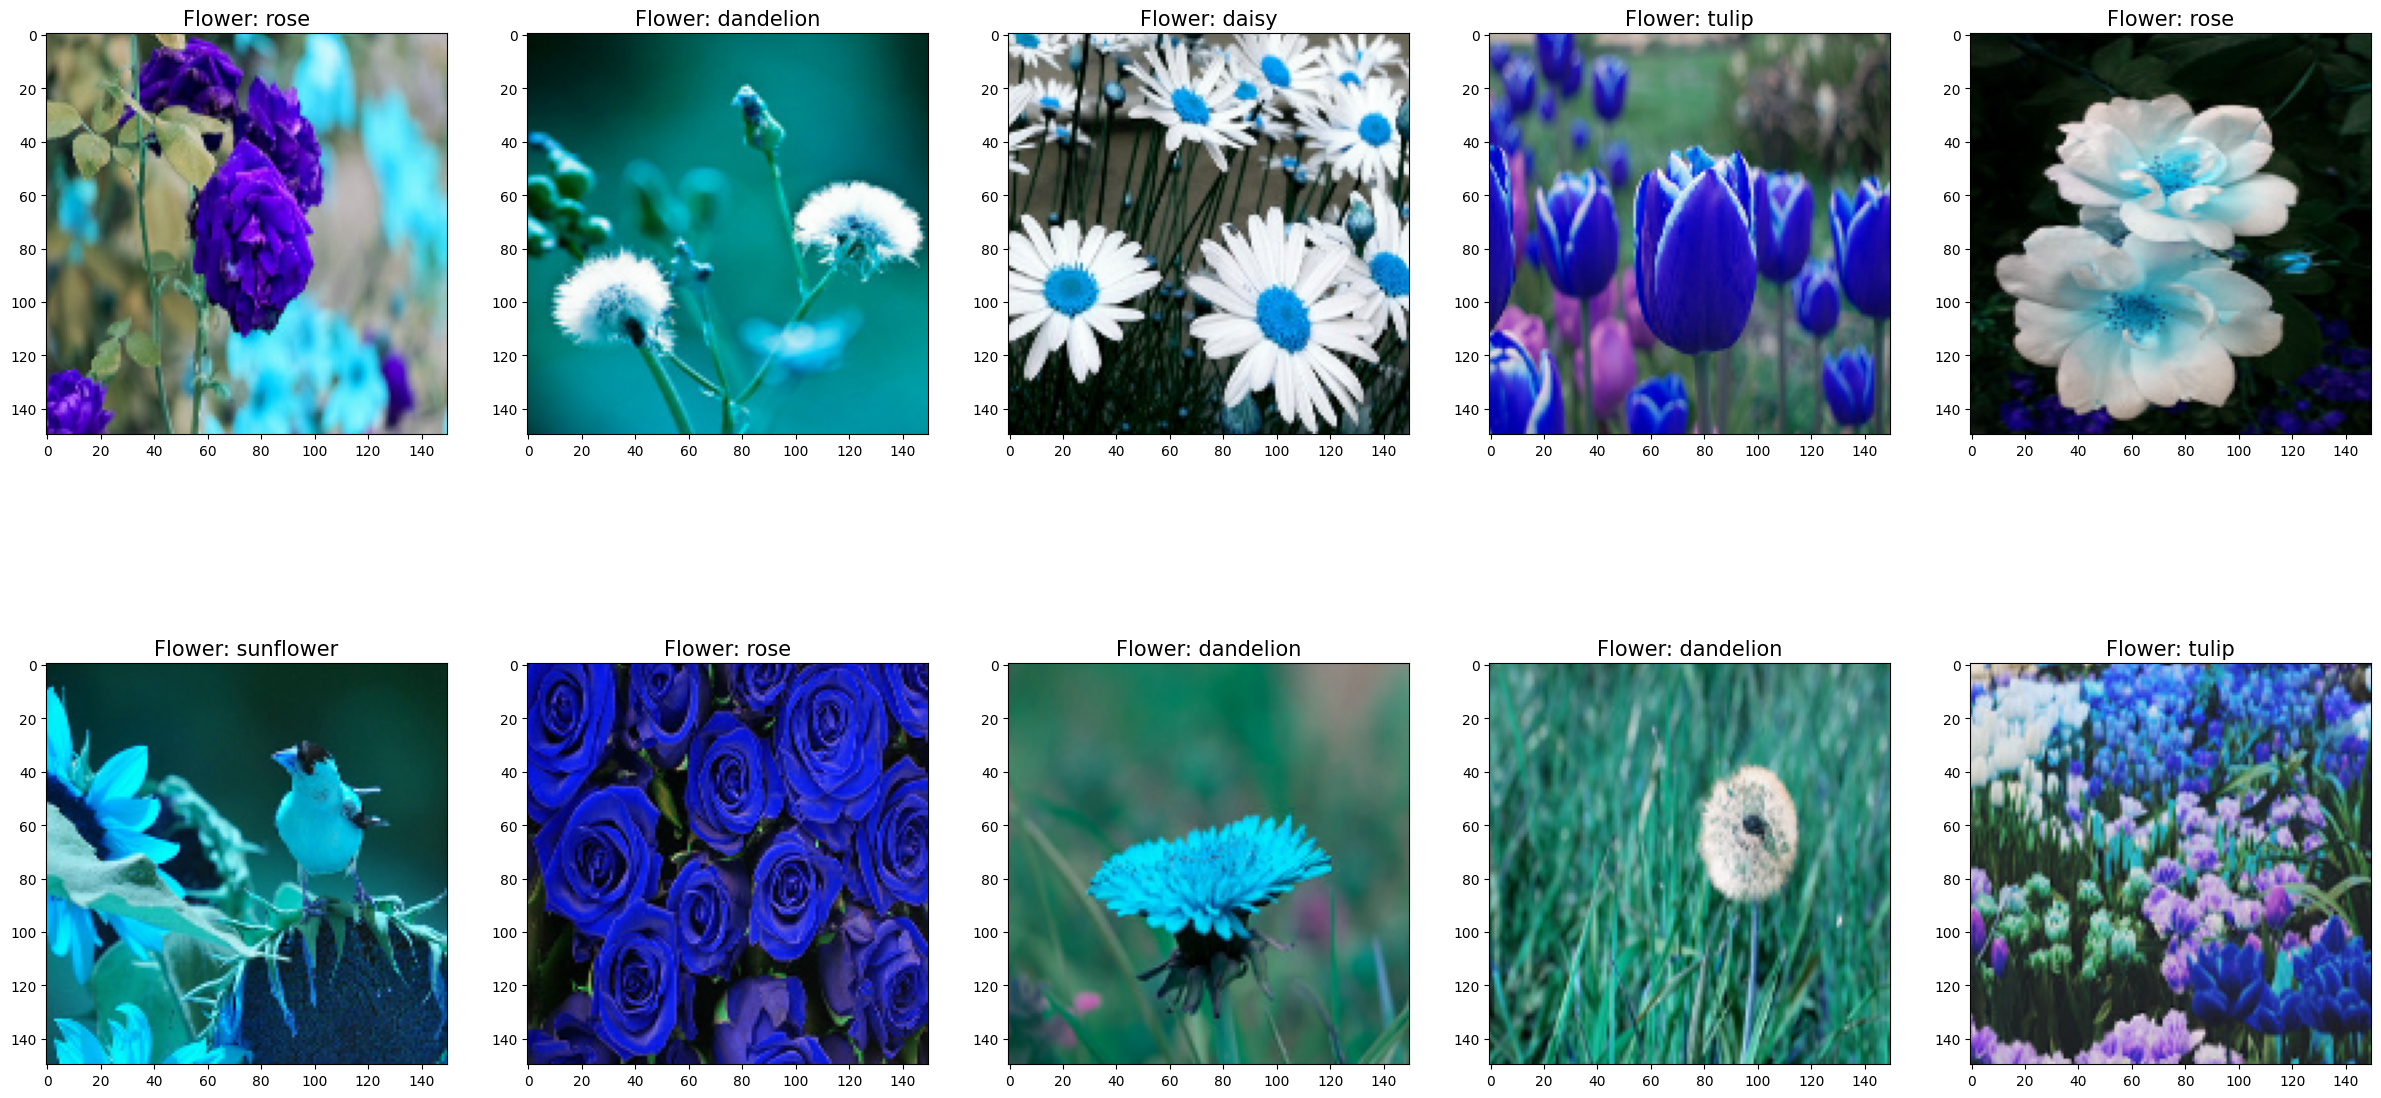

In [ ]:
# Visualize some random images from the dataset
fig, ax = plt.subplots(2, 5)
fig.set_size_inches(30, 15)
# Plot 10 images
for i in range(2):
    for j in range(5):
        index = random.randint(0, len(X))
        ax[i, j].imshow(X[index])
        ax[i, j].set_title('Flower: ' + categories[y[index]], fontsize=15)

Class labels are distributed

Text(0.5, 1.0, 'Class Distribution')

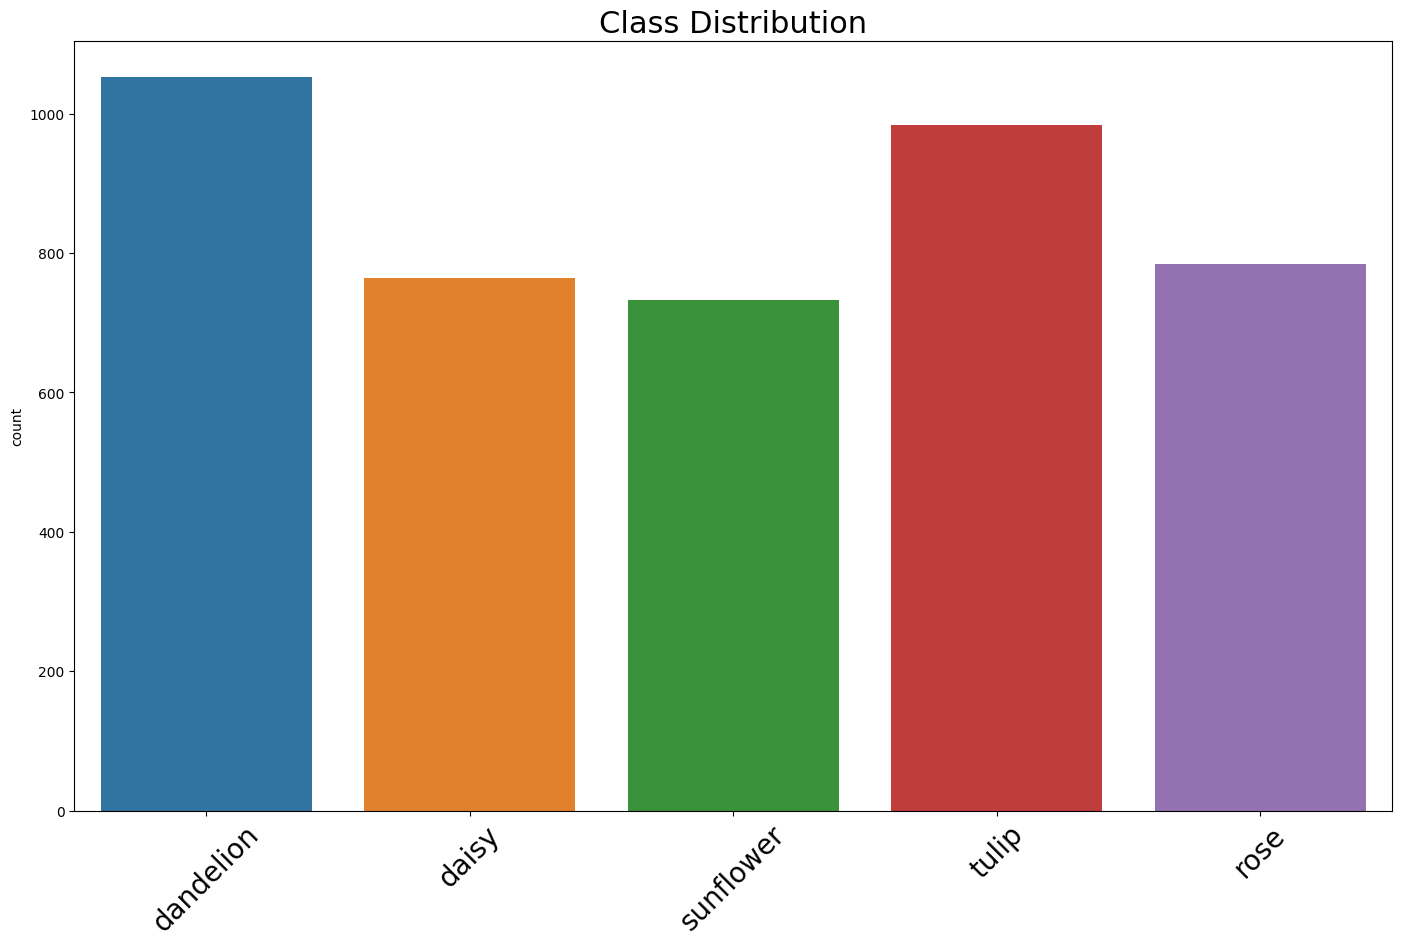

In [ ]:
# Class labels distributed
# Explore class distribution
plt.figure(figsize=(17, 10))
sns.countplot(x=[categories[i] for i in y])
plt.xticks(rotation=45, fontsize=20)
plt.title("Class Distribution", fontsize=22)

Check for noises

In [ ]:
# Check for image noise and print results
def check_for_noise(image, noise_threshold=30):
    # Ensure the image is in 8-bit format
    image = cv2.convertScaleAbs(image)

    # Convert the image to grayscale for noise analysis
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Calculate the standard deviation of pixel intensities in the grayscale image
    std_dev = np.std(gray_image)

    # Check if the standard deviation exceeds the noise threshold
    return std_dev > noise_threshold

all_noise_free = True

for i, img in enumerate(X):
    is_noisy = check_for_noise(img)
    if is_noisy:
        print(f"Image {i + 1} has noise.")
        all_noise_free = False

if all_noise_free:
    print("All images are noise-free.")

All images are noise-free.


Balancing the data

In [ ]:
''' This code balances the class distribution by undersampling the majority of classes randomly to match the count of the minority classes.
    This is commonly done to prevent the model from being biased towards the majority class during training.
'''

# Count the number of samples in each class
class_counts = dict(zip(*np.unique(y, return_counts=True)))

# Find the class with the fewest samples
min_class = min(class_counts, key=class_counts.get)
min_count = class_counts[min_class]

# Perform random undersampling of the majority classes
X_balanced = []
y_balanced = []

# Ensure that at least one sample from the class with the fewest instances is included
for cls in class_counts:
    X_majority = X[y == cls]

    if cls == min_class:
        X_majority_sampled = X_majority
    else:
        X_majority_sampled = resample(X_majority, n_samples=min_count, random_state=42)

    X_balanced.append(X_majority_sampled)
    y_balanced.extend([cls] * len(X_majority_sampled))

X_balanced = np.vstack(X_balanced)
y_balanced = np.array(y_balanced)

# Check the class distribution after undersampling
class_counts = Counter(y_balanced)

# Convert the Counter object to a list of counts
class_counts_list = [class_counts[class_label] for class_label in sorted(class_counts.keys())]

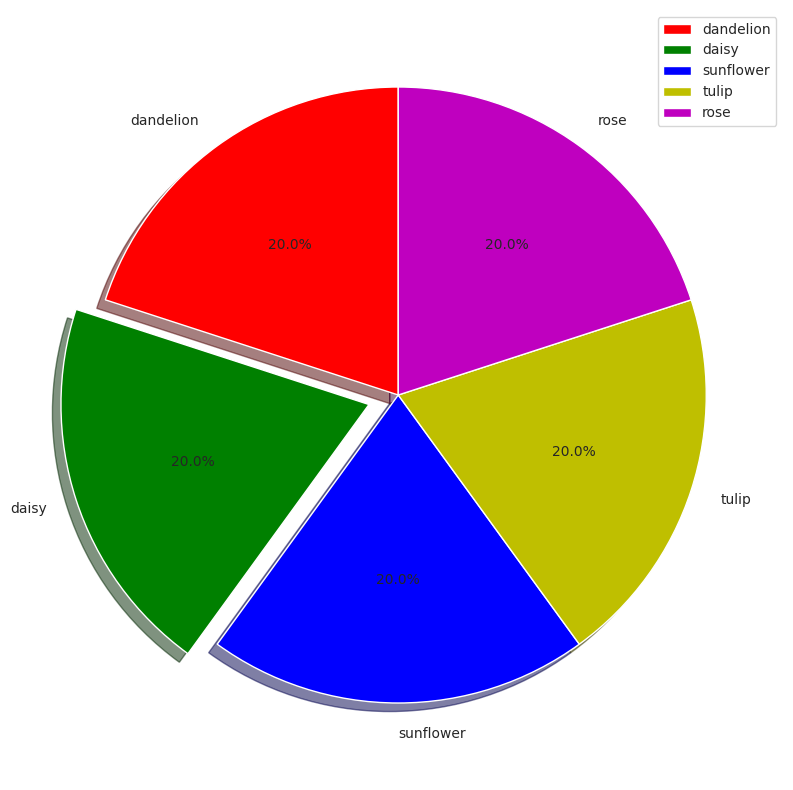

In [ ]:
# Visualize the class distribution after balancing
sns.set_style('whitegrid')
plt.figure(figsize=(18, 10))
plt.pie(class_counts_list, labels=categories, startangle=90, colors=['r', 'g', 'b', 'y', 'm'], autopct='%1.1f%%', explode=(0, 0.1, 0, 0, 0), shadow=True)
plt.legend()
plt.show()

Split the data into a training and test set

In [ ]:
# Split data into a training and set test
X_balanced.shape

(3665, 150, 150, 3)

This part is responsible for splitting the balanced dataset into training and testing sets.

In [ ]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_balanced, y_balanced, test_size=0.2, random_state=42)
print("X_train shape :",X_train.shape)
print("y_train shape :",y_train.shape)
print("X_test shape :" ,X_test.shape)
print("y_test shape :",y_test.shape)

X_train shape : (2932, 150, 150, 3)
y_train shape : (2932,)
X_test shape : (733, 150, 150, 3)
y_test shape : (733,)


In [ ]:
# Optionally, you can one-hot encode the labels if you plan to use deep learning models but since this is a cnn...
''' one-hot encode to convert the labels into a binary matrix
    Dealing with categorical cross-entropy loss in neural networks, it provides a good way to represent categorical labels in a format that
    is useful for neural networks. '''
y_train = to_categorical(y_train, num_classes=len(categories))
y_test = to_categorical(y_test, num_classes=len(categories))

In [ ]:
'''
    During training we use image augmentation to generate new images from the existing ones.
    We do this by using the ImageDataGenerator class from Keras to provide the model with a stream of augmented images samples for training.'''

model = keras.Sequential([
    layers.Conv2D(32, (3, 3), input_shape=(150, 150, 3), activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Dropout(0.3),

    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Dropout(0.3),

    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Flatten(),
    layers.Dense(512, activation="relu"),
    layers.Dropout(0.3),
    layers.Dense(len(categories), activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy']) #keras.optimizers.Adam(1e-3)

# Assuming data is properly preprocessed, one-hot encoded, and loaded
# X_train, y_train, X_test, y_test = ...

datagen = ImageDataGenerator(rotation_range=20, width_shift_range=0.2, height_shift_range=0.2, horizontal_flip=True)
datagen.fit(X_train)

# Train the model
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=30, batch_size=32)

Epoch 1/30
92/92 [==============================] - 177s 2s/step - loss: 1.5899 - accuracy: 0.3417 - val_loss: 1.2143 - val_accuracy: 0.5416
Epoch 2/30
92/92 [==============================] - 183s 2s/step - loss: 1.1254 - accuracy: 0.5389 - val_loss: 1.0710 - val_accuracy: 0.5648
Epoch 3/30
92/92 [==============================] - 177s 2s/step - loss: 0.9393 - accuracy: 0.6368 - val_loss: 0.8601 - val_accuracy: 0.6780
Epoch 4/30
92/92 [==============================] - 190s 2s/step - loss: 0.7756 - accuracy: 0.7005 - val_loss: 0.7908 - val_accuracy: 0.7040
Epoch 5/30
92/92 [==============================] - 176s 2s/step - loss: 0.5553 - accuracy: 0.7981 - val_loss: 0.7065 - val_accuracy: 0.7422
Epoch 6/30
92/92 [==============================] - 174s 2s/step - loss: 0.4257 - accuracy: 0.8458 - val_loss: 0.7030 - val_accuracy: 0.7490
Epoch 7/30
92/92 [==============================] - 177s 2s/step - loss: 0.2929 - accuracy: 0.9035 - val_loss: 0.6723 - val_accuracy: 0.7885
Epoch 8/30
92

In [ ]:
# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test accuracy: {test_acc}")

23/23 [==============================] - 9s 370ms/step - loss: 1.3801 - accuracy: 0.8076
Test accuracy: 0.8076398372650146


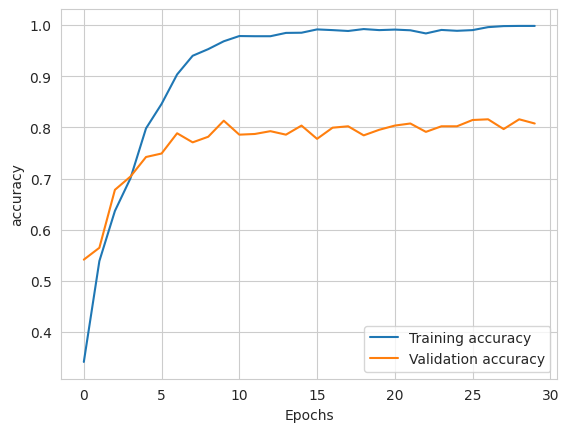

In [ ]:
# Plotting the training and validation loss

plt.plot(history.history['accuracy'], label='Training accuracy')
plt.plot(history.history['val_accuracy'], label='Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()

23/23 [==============================] - 10s 419ms/step


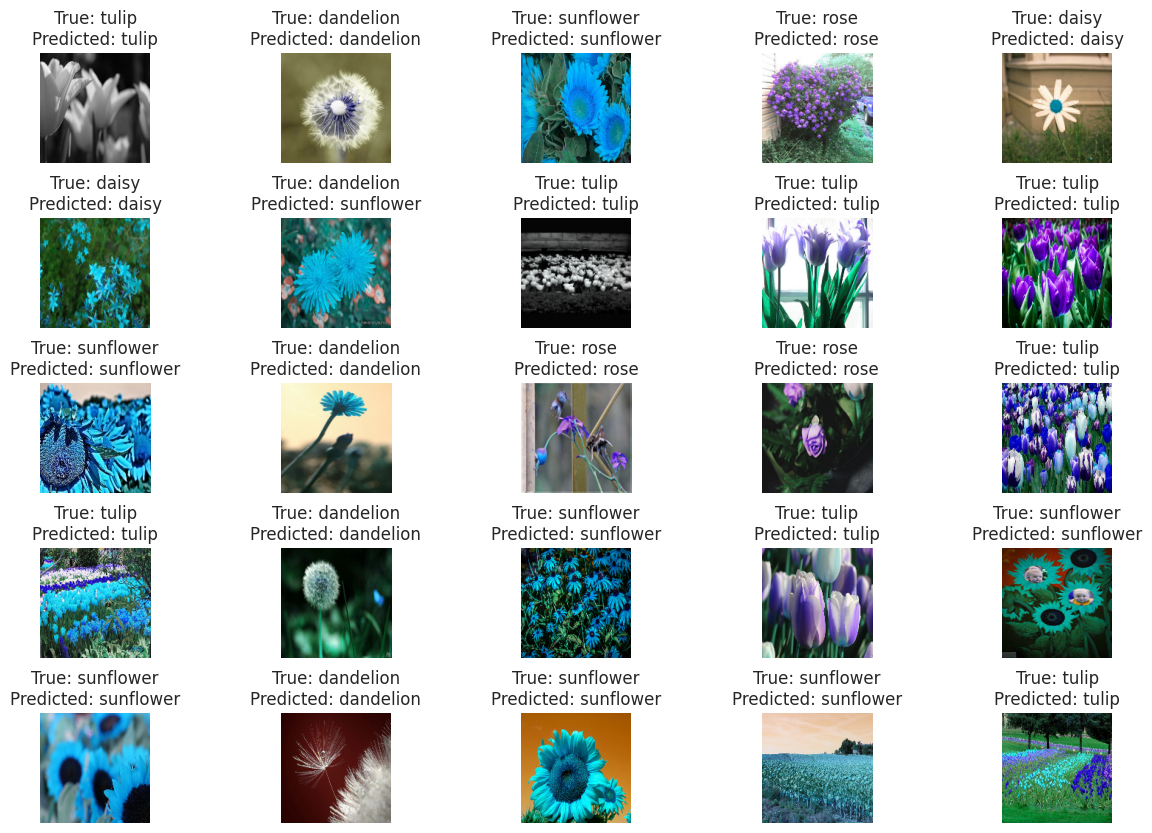

In [ ]:
# Make predictions on the test set
predictions = model.predict(X_test)

# Get the class labels for the predictions
predicted_labels = np.argmax(predictions, axis=1)

# Get the true class labels for the test set
true_labels = np.argmax(y_test, axis=1)

# Define a function to display images with labels
def display_images_with_labels(images, true_labels, predicted_labels, class_names):
    fig, axes = plt.subplots(5, 5, figsize=(15, 10))

    # Increase the space between rows
    fig.subplots_adjust(hspace=0.5)

    for i, ax in enumerate(axes.flat):
        ax.imshow(images[i])
        ax.axis('off')
        true_label = class_names[true_labels[i]]
        predicted_label = class_names[predicted_labels[i]]
        title = f"True: {true_label}\nPredicted: {predicted_label}"
        ax.set_title(title)

# Assuming you have a list of class names
class_names = ['dandelion', 'daisy', 'sunflower', 'tulip', 'rose']

# Display a random sample of test images
sample_indices = np.random.choice(len(X_test), 25, replace=False)
sample_images = X_test[sample_indices]
sample_true_labels = true_labels[sample_indices]
sample_predicted_labels = predicted_labels[sample_indices]

display_images_with_labels(sample_images, sample_true_labels, sample_predicted_labels, class_names)
plt.show()

In [ ]:
from sklearn.metrics import precision_score, recall_score,f1_score


f1 = f1_score(true_labels, predicted_labels, average='micro')

# Output the result
print("F1 Score:", f1)

F1 Score: 0.8076398362892225
